In [ ]:
!pip install mne
!pip install pyriemann

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 kB 4.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import mne
from scipy.io import loadmat
from scipy.signal import welch
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for entropy: filename=entropy-0.1.5-py3-none-any.whl size=7178 sha256=a1cca608d5affbbf2cf41f8d89b67a8f8887b4374da75f394b69e32c1ebff345
  Stored in directory: /root/.cache/pip/wheels/81/ab/6d/d247a2eb9e7b8968acceab1d0531f2930ccf6688b61c0de460
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=da2a434d48b8351d41d621c3120db25b35a13f22b8c6135c6708560a6e63f34b
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built entropy docopt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Función para crear épocas
def create_epochs(starting_dir="/content/drive/MyDrive/Hackathon/", item='P1_high1.mat'):
    eeg_ch = ['Fz', 'C3', 'Cz', 'C4', 'CP1', 'CPz', 'CP2', 'Pz']
    fs = 256

    file_name = os.path.join(starting_dir, item)
    data = loadmat(file_name)
    eeg_data = data['y']
    stim_data = data['trig']

    stim_data[stim_data == -1] = 3
    info = mne.create_info(ch_names=eeg_ch, sfreq=fs, ch_types='eeg')
    info.set_montage('standard_1020')
    raw = mne.io.RawArray(eeg_data.T, info)

    info_event = mne.create_info(['STI'], sfreq=fs, ch_types='stim')
    stim_raw = mne.io.RawArray(stim_data.T, info_event)
    raw.add_channels([stim_raw], force_update_info=True)

    events = mne.find_events(raw, stim_channel='STI')
    event_id = {'nontarget': 1, 'target': 2}

    raw.notch_filter(freqs=50)
    raw.filter(l_freq=1, h_freq=12)

    epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.1, tmax=0.6,
                        preload=True)

    return epochs

In [ ]:


class OptimizedFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, fs=256):
        self.fs = fs
        # Bandas ajustadas para P300
        self.spectral_bands = [(1,4), (4,8), (8,12)]  # Delta, Theta, Alpha

    def fit(self, X, y=None):
        return self

    def transform(self, epochs):
        X = epochs.get_data()
        features = []

        for epoch in X:
            epoch_features = []

            # 1. Características temporales esenciales
            epoch_features.extend([
                np.mean(epoch, axis=1),       # Media (componente DC)
                np.std(epoch, axis=1),        # Variabilidad
                np.ptp(epoch, axis=1),        # Rango dinámico
                np.sum(np.abs(np.diff(epoch, axis=1)), axis=1)  # Actividad temporal
            ])

            # 2. Características espectrales
            freqs, psd = welch(epoch, fs=self.fs, nperseg=min(64, epoch.shape[1]))

            for band in self.spectral_bands:
                band_mask = (freqs >= band[0]) & (freqs <= band[1])
                # Potencia absoluta y relativa
                band_power = np.mean(psd[:, band_mask], axis=1)
                total_power = np.mean(psd[:, (freqs >= 1) & (freqs <= 12)], axis=1)
                rel_power = band_power / (total_power + 1e-10)  # Evitar división por cero

                epoch_features.extend([band_power, rel_power])

            # 3. Características de conectividad simple (opcional)
            #if epoch.shape[0] > 1:  # Si hay múltiples canales
             #   corr_matrix = np.corrcoef(epoch)
              #  upper_tri = corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)]
               # epoch_features.append(upper_tri)

            features.append(np.concatenate(epoch_features))

        features = np.array(features)
        features = np.nan_to_num(features, nan=np.nanmean(features))
        return features



In [ ]:
# 2. Extractor de características simplificado
class SimpleFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, fs=256):
        self.fs = fs
        self.spectral_bands = [(1,4), (4,8), (8,12)]  # Bandas delta, theta, alpha, beta

    def fit(self, X, y=None):
        return self

    def transform(self, epochs):
        X = epochs.get_data()
        features = []

        for epoch in X:
            epoch_features = []

            # Características temporales
            epoch_features.extend([
                np.mean(epoch, axis=1),    # Media
                np.std(epoch, axis=1),     # Desviación estándar
                np.ptp(epoch, axis=1),      # Rango pico a pico
                np.max(epoch, axis=1) - np.min(epoch, axis=1),     # Valor mínimo
                np.var(epoch, axis=1),             # Varianza
                np.median(epoch, axis=1),          # Mediana
                np.sum(np.abs(np.diff(epoch, axis=1)), axis=1),  # Suma de diferencias absolutas
                np.mean(np.abs(np.diff(epoch, axis=1)), axis=1), # Media de diferencias absolutas
                np.max(np.abs(np.diff(epoch, axis=1)), axis=1),  # Valor máximo de diferencias absolutas

            ])

            # Características espectrales
            freqs, psd = welch(epoch, fs=self.fs, nperseg=min(64, epoch.shape[1]))
            for band in self.spectral_bands:
                band_mask = (freqs >= band[0]) & (freqs <= band[1])
                epoch_features.append(np.mean(psd[:, band_mask], axis=1))

            features.append(np.concatenate(epoch_features))

        features = np.array(features)
        features = np.nan_to_num(features, nan=np.nanmean(features))
        return features

In [ ]:
# 3. Evaluación con modelos específicos para P300
def evaluate_p300_models(X, y, dataset_name):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = ['nontarget', 'target']

    # Configuración básica del pipeline
    base_steps = [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
        #('pca', PCA(n_components=0.95))
    ]

    # Modelos específicos para P300
    models = {
        'RandomForest': ImbPipeline(base_steps + [
            ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
        ]),
        'SVM': ImbPipeline(base_steps + [
            ('model', SVC(class_weight='balanced', probability=True, random_state=42))
        ]),
        'LogisticRegression': ImbPipeline(base_steps + [
            ('model', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        'LDA': ImbPipeline(base_steps + [
            ('model', LinearDiscriminantAnalysis())
        ])
    }

    # Parámetros para GridSearch
    params = {
        'RandomForest': {'model__n_estimators': [100, 200]},
        'SVM': {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']},
        'LogisticRegression': {'model__C': [0.1, 1, 10]},
        'LDA': {}
    }

    results = {}
    for name in models:
        print(f"\n=== Evaluando {name} en {dataset_name} ===")
        try:
            n_splits = min(5, np.min(np.bincount(y_encoded)))
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

            model = GridSearchCV(
                models[name],
                params.get(name, {}),
                cv=cv,
                scoring='accuracy',
                #scoring='f1_weighted',
                n_jobs=-1
            )

            y_pred = cross_val_predict(model, X, y_encoded, cv=cv)

            # Calcular métricas
            report = classification_report(
                y_encoded, y_pred, target_names=class_names, output_dict=True
            )
            cm = confusion_matrix(y_encoded, y_pred)

            # Métricas por clase
            metrics = {
                'classification_report': report,
                'auc': roc_auc_score(y_encoded, y_pred),
                'balanced_accuracy': balanced_accuracy_score(y_encoded, y_pred),
                'confusion_matrix': cm,
                'f1_nontarget': report['nontarget']['f1-score'],
                'f1_target': report['target']['f1-score'],
                'recall_nontarget': report['nontarget']['recall'],
                'recall_target': report['target']['recall']
            }

            results[name] = metrics

            # Mostrar métricas
            print(f"\nMétricas para {name}:")
            print(f"F1-score (nontarget): {metrics['f1_nontarget']:.3f}")
            print(f"F1-score (target): {metrics['f1_target']:.3f}")
            print(f"Recall (nontarget): {metrics['recall_nontarget']:.3f}")
            print(f"Recall (target): {metrics['recall_target']:.3f}")
            print(f"AUC: {metrics['auc']:.3f}")

            # Visualizar matriz de confusión
            plt.figure(figsize=(6, 5))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title(f"Matriz de Confusión\n{name}")

            # Etiquetas de ejes con nombres de clases
            tick_marks = np.arange(len(class_names))
            plt.xticks(tick_marks, class_names, rotation=45)
            plt.yticks(tick_marks, class_names)

            # Anotar valores en la matriz
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    plt.text(j, i, format(cm[i, j], 'd'),
                             horizontalalignment="center",
                             color="white" if cm[i, j] > thresh else "black")

            plt.ylabel('Etiqueta Real')
            plt.xlabel('Etiqueta Predicha')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error en {name}: {str(e)}")
            results[name] = {'error': str(e)}

    return results

In [ ]:
# 3. Evaluación con modelos específicos para P300
def evaluate_p300_models(X, y, dataset_name):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = ['nontarget', 'target']

    # Configuración básica del pipeline
    base_steps = [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
    # Modelos específicos para P300
    models = {
        'RandomForest': ImbPipeline(base_steps + [
            ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
        ]),
        'SVM': ImbPipeline(base_steps + [
            ('model', SVC(class_weight='balanced', probability=True, random_state=42))
        ]),
        'LogisticRegression': ImbPipeline(base_steps + [
            ('model', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        'LDA': ImbPipeline(base_steps + [
            ('model', LinearDiscriminantAnalysis())
        ])
    }
    results = {}
    for name in models:
        print(f"\n=== Evaluando {name} en {dataset_name} ===")
        try:
            n_splits = min(5, np.min(np.bincount(y_encoded)))
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

            model = models[name]

            y_pred = cross_val_predict(model, X, y_encoded, cv=cv)

            # Calcular métricas
            report = classification_report(
                y_encoded, y_pred, target_names=class_names, output_dict=True
            )
            cm = confusion_matrix(y_encoded, y_pred)

            # Métricas por clase
            metrics = {
                'classification_report': report,
                'auc': roc_auc_score(y_encoded, y_pred),
                'balanced_accuracy': balanced_accuracy_score(y_encoded, y_pred),
                'confusion_matrix': cm,
                'f1_nontarget': report['nontarget']['f1-score'],
                'f1_target': report['target']['f1-score'],
                'recall_nontarget': report['nontarget']['recall'],
                'recall_target': report['target']['recall']
            }

            results[name] = metrics

            # Mostrar métricas
            print(f"\nMétricas para {name}:")
            print(f"F1-score (nontarget): {metrics['f1_nontarget']:.3f}")
            print(f"F1-score (target): {metrics['f1_target']:.3f}")
            print(f"Recall (nontarget): {metrics['recall_nontarget']:.3f}")
            print(f"Recall (target): {metrics['recall_target']:.3f}")
            print(f"AUC: {metrics['auc']:.3f}")

            # Visualizar matriz de confusión
            plt.figure(figsize=(6, 5))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title(f"Matriz de Confusión\n{name}")

            # Etiquetas de ejes con nombres de clases
            tick_marks = np.arange(len(class_names))
            plt.xticks(tick_marks, class_names, rotation=45)
            plt.yticks(tick_marks, class_names)

            # Anotar valores en la matriz
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    plt.text(j, i, format(cm[i, j], 'd'),
                             horizontalalignment="center",
                             color="white" if cm[i, j] > thresh else "black")

            plt.ylabel('Etiqueta Real')
            plt.xlabel('Etiqueta Predicha')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error en {name}: {str(e)}")
            results[name] = {'error': str(e)}

    return results

In [ ]:
# 4. Visualización de resultados principales
def plot_main_results(results, dataset_name):
    if not results:
        return

    # Crear figura con múltiples subplots
    plt.figure(figsize=(18, 6))

    # Gráfico de F1-score por clase
    plt.subplot(1, 3, 1)
    model_names = [name for name in results if isinstance(results[name], dict)]

    f1_nontarget = [results[name]['f1_nontarget'] for name in model_names]
    f1_target = [results[name]['f1_target'] for name in model_names]

    bar_width = 0.35
    index = np.arange(len(model_names))

    plt.bar(index, f1_nontarget, bar_width, label='Nontarget')
    plt.bar(index + bar_width, f1_target, bar_width, label='Target')

    plt.xlabel('Modelos')
    plt.ylabel('F1-score')
    plt.title('F1-score por clase')
    plt.xticks(index + bar_width/2, model_names, rotation=45)
    plt.legend()
    plt.ylim(0, 1)

    # Gráfico de Recall por clase
    plt.subplot(1, 3, 2)
    recall_nontarget = [results[name]['recall_nontarget'] for name in model_names]
    recall_target = [results[name]['recall_target'] for name in model_names]

    plt.bar(index, recall_nontarget, bar_width, label='Nontarget')
    plt.bar(index + bar_width, recall_target, bar_width, label='Target')

    plt.xlabel('Modelos')
    plt.ylabel('Recall')
    plt.title('Recall por clase')
    plt.xticks(index + bar_width/2, model_names, rotation=45)
    plt.legend()
    plt.ylim(0, 1)

    # Gráfico de AUC
    plt.subplot(1, 3, 3)
    auc_scores = [results[name]['auc'] for name in model_names]
    plt.bar(model_names, auc_scores)
    plt.xlabel('Modelos')
    plt.ylabel('AUC')
    plt.title('AUC Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

    plt.suptitle(f"Resultados por clase para {dataset_name}")
    plt.tight_layout()
    plt.show()


In [ ]:
# 5. Pipeline completo para cada dataset
def process_dataset(item, starting_dir):
    print(f"\n{'='*50}\nProcesando: {item}\n{'='*50}")

    try:
        # 1. Cargar datos
        epochs = create_epochs(starting_dir, item)

        # 2. Extraer características
        #feature_extractor = SimpleFeatureExtractor(fs=256)
        feature_extractor = OptimizedFeatureExtractor(fs=256)
        X = feature_extractor.transform(epochs)
        y = epochs.events[:, -1]

        # 3. Evaluar modelos
        results = evaluate_p300_models(X, y, item)

        # 4. Visualizar resultados principales
        plot_main_results(results, item)

        return results

    except Exception as e:
        print(f"Error procesando {item}: {str(e)}")
        return None


Procesando: P1_high1.mat
Creating RawArray with float64 data, n_channels=8, n_times=38976
    Range : 0 ... 38975 =      0.000 ...   152.246 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=38976
    Range : 0 ... 38975 =      0.000 ...   152.246 secs
Ready.
480 events found on stim channel STI
Event IDs: [1 2 3]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 12 Hz

FIR filter 

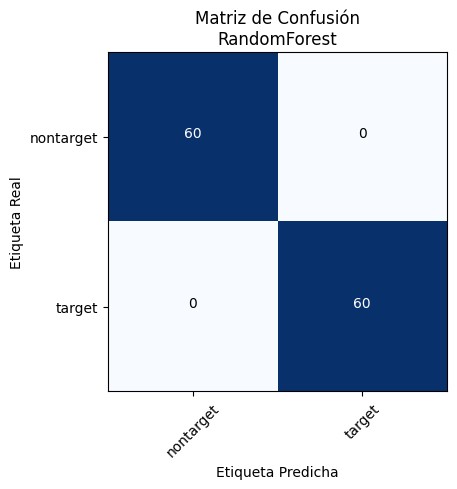


=== Evaluando SVM en P1_high1.mat ===

Métricas para SVM:
F1-score (nontarget): 0.842
F1-score (target): 0.857
Recall (nontarget): 0.800
Recall (target): 0.900
AUC: 0.850


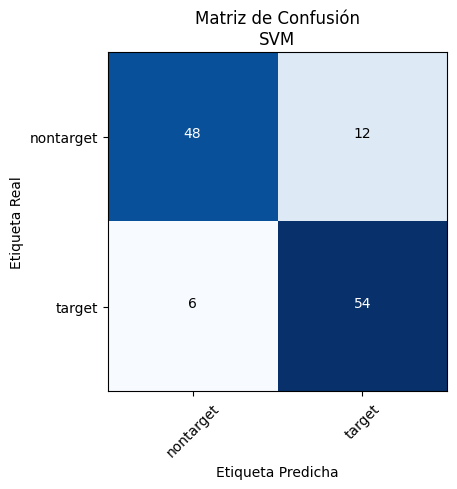


=== Evaluando LogisticRegression en P1_high1.mat ===

Métricas para LogisticRegression:
F1-score (nontarget): 0.885
F1-score (target): 0.881
Recall (nontarget): 0.900
Recall (target): 0.867
AUC: 0.883


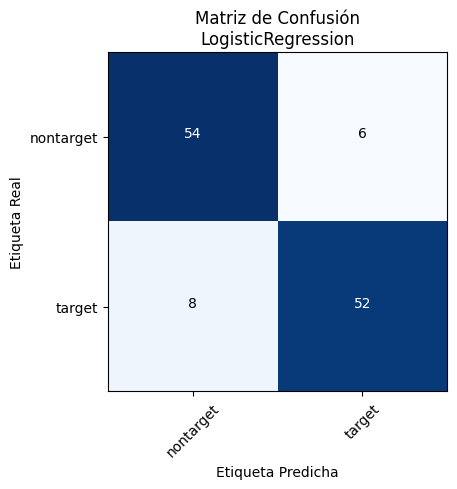


=== Evaluando LDA en P1_high1.mat ===

Métricas para LDA:
F1-score (nontarget): 0.754
F1-score (target): 0.778
Recall (nontarget): 0.717
Recall (target): 0.817
AUC: 0.767


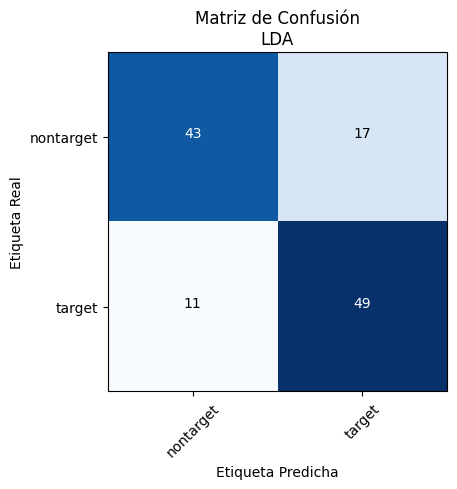

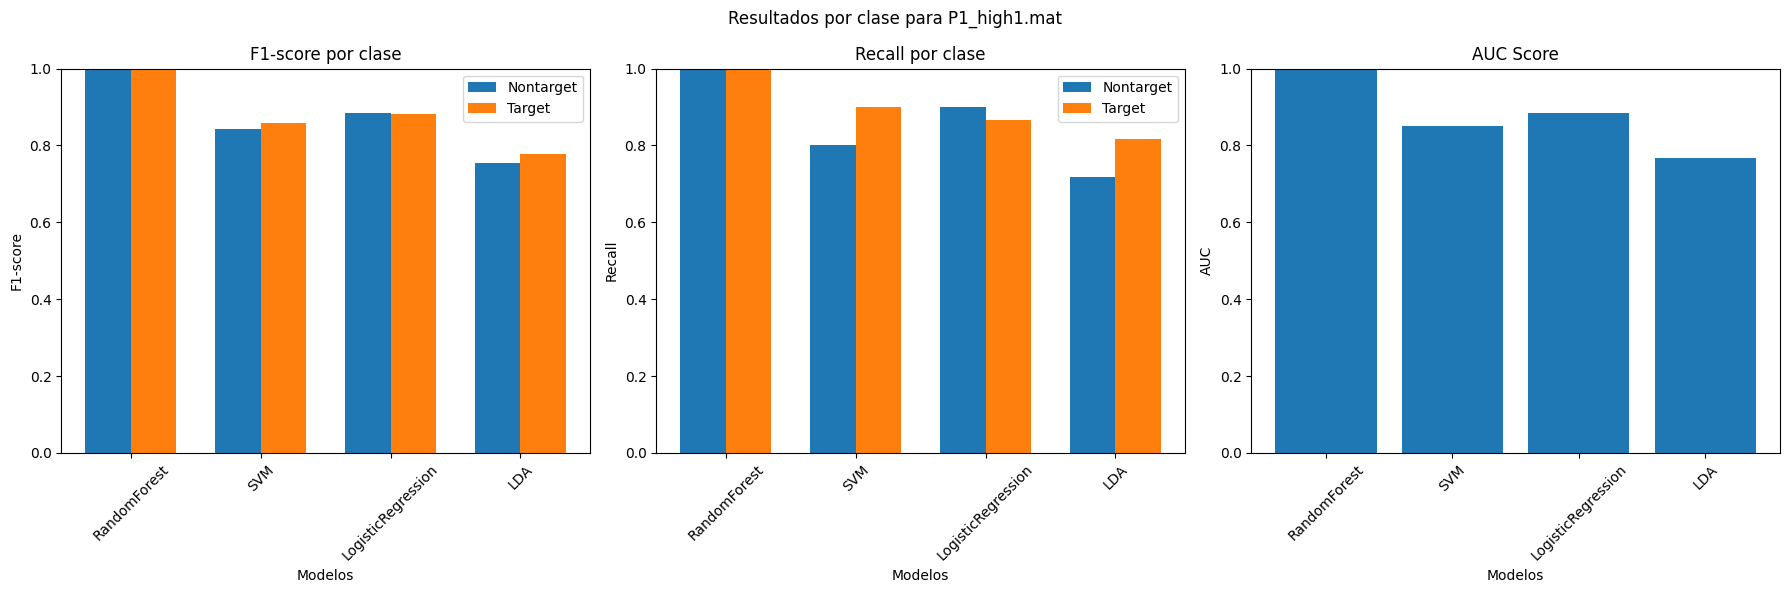


Procesando: P1_high2.mat
Creating RawArray with float64 data, n_channels=8, n_times=39000
    Range : 0 ... 38999 =      0.000 ...   152.340 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=39000
    Range : 0 ... 38999 =      0.000 ...   152.340 secs
Ready.
480 events found on stim channel STI
Event IDs: [1 2 3]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 12 Hz

FIR filter 

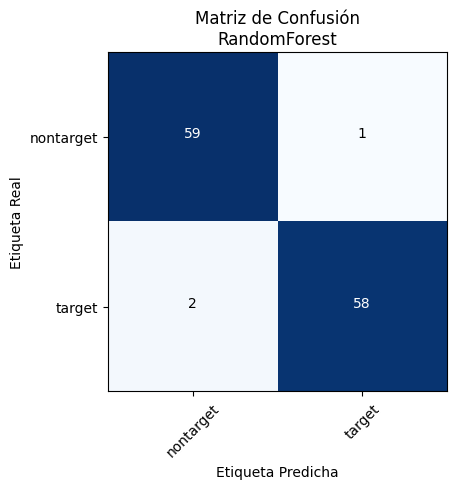


=== Evaluando SVM en P1_high2.mat ===

Métricas para SVM:
F1-score (nontarget): 0.789
F1-score (target): 0.824
Recall (nontarget): 0.717
Recall (target): 0.900
AUC: 0.808


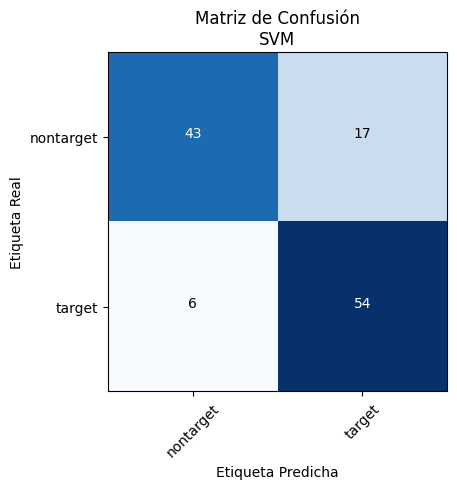


=== Evaluando LogisticRegression en P1_high2.mat ===

Métricas para LogisticRegression:
F1-score (nontarget): 0.957
F1-score (target): 0.959
Recall (nontarget): 0.933
Recall (target): 0.983
AUC: 0.958


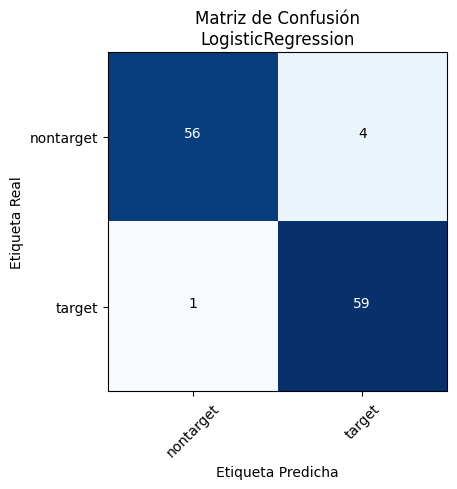


=== Evaluando LDA en P1_high2.mat ===

Métricas para LDA:
F1-score (nontarget): 0.814
F1-score (target): 0.835
Recall (nontarget): 0.767
Recall (target): 0.883
AUC: 0.825


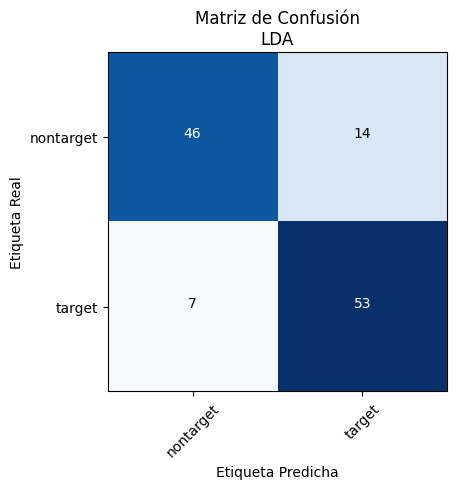

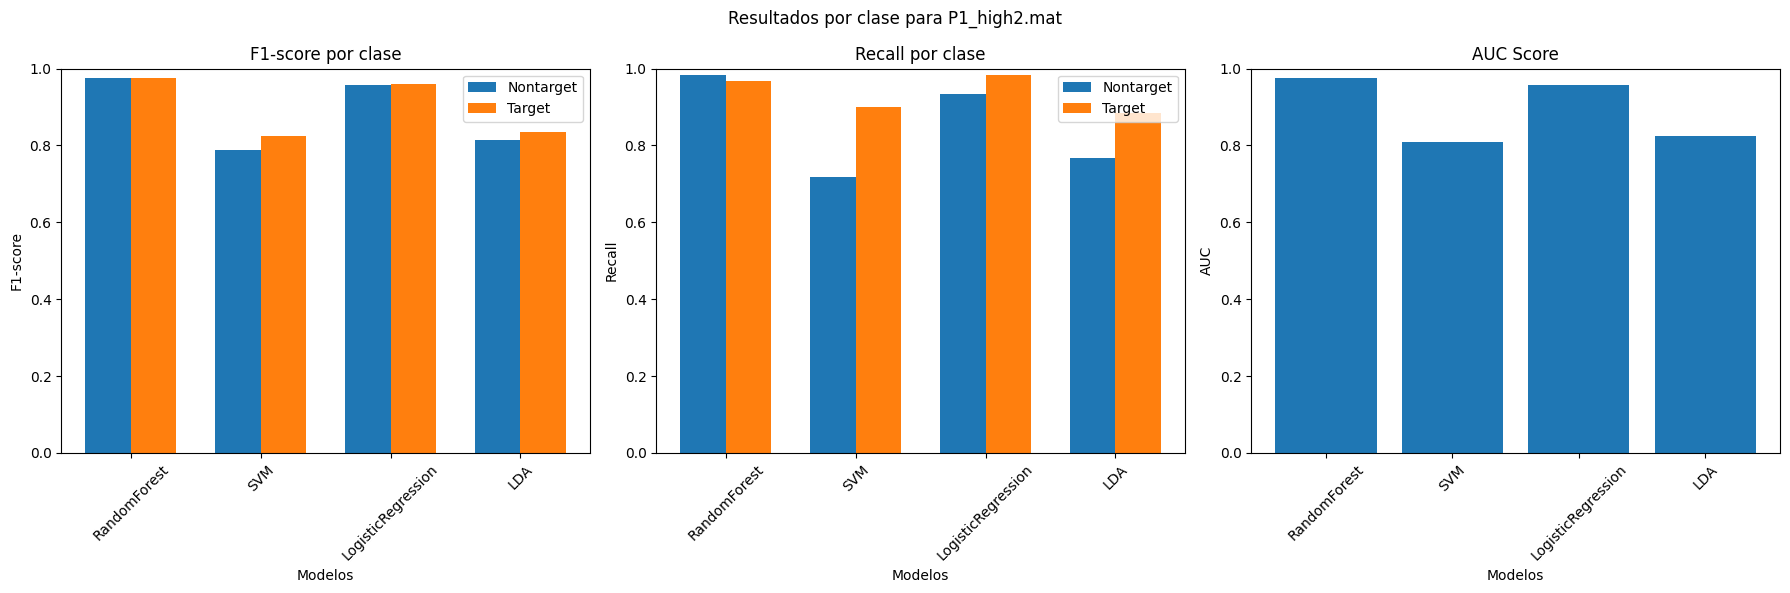


Procesando: P2_high1.mat
Creating RawArray with float64 data, n_channels=8, n_times=39280
    Range : 0 ... 39279 =      0.000 ...   153.434 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=39280
    Range : 0 ... 39279 =      0.000 ...   153.434 secs
Ready.
480 events found on stim channel STI
Event IDs: [1 2 3]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 12 Hz

FIR filter 

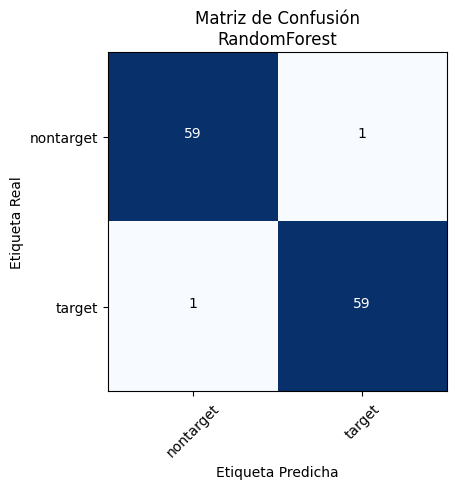


=== Evaluando SVM en P2_high1.mat ===

Métricas para SVM:
F1-score (nontarget): 0.758
F1-score (target): 0.741
Recall (nontarget): 0.783
Recall (target): 0.717
AUC: 0.750


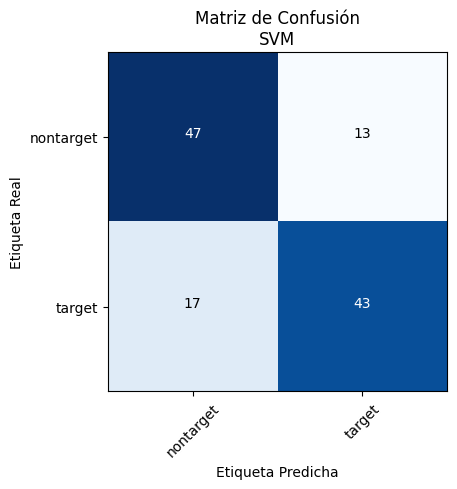


=== Evaluando LogisticRegression en P2_high1.mat ===

Métricas para LogisticRegression:
F1-score (nontarget): 0.700
F1-score (target): 0.700
Recall (nontarget): 0.700
Recall (target): 0.700
AUC: 0.700


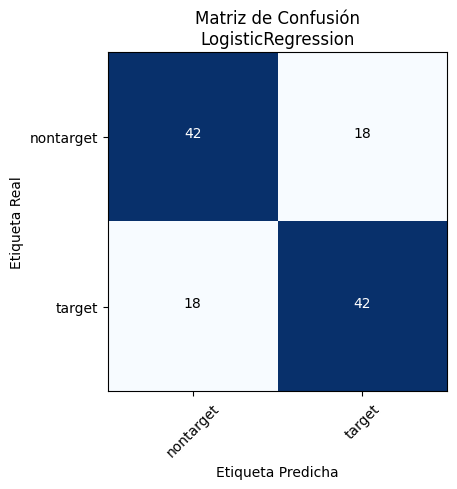


=== Evaluando LDA en P2_high1.mat ===

Métricas para LDA:
F1-score (nontarget): 0.730
F1-score (target): 0.702
Recall (nontarget): 0.767
Recall (target): 0.667
AUC: 0.717


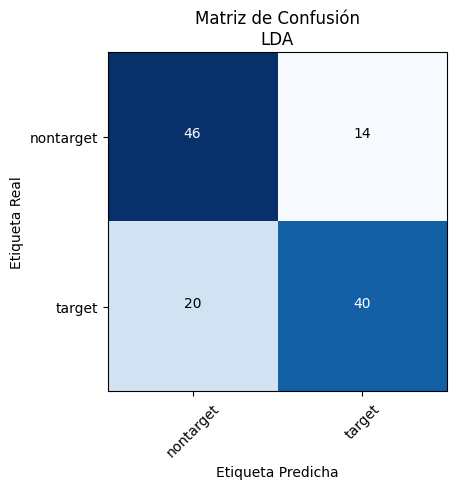

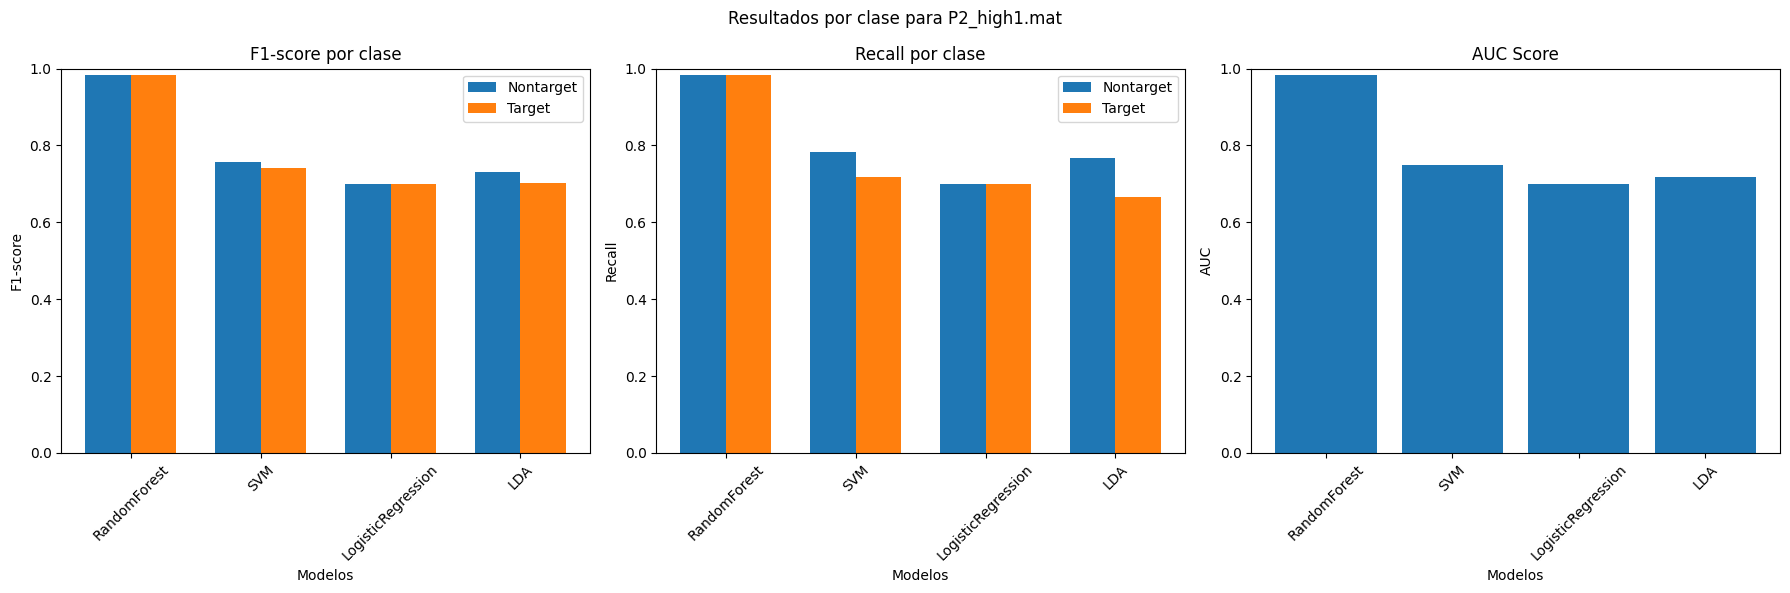


Procesando: P2_high2.mat
Creating RawArray with float64 data, n_channels=8, n_times=39720
    Range : 0 ... 39719 =      0.000 ...   155.152 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=39720
    Range : 0 ... 39719 =      0.000 ...   155.152 secs
Ready.
480 events found on stim channel STI
Event IDs: [1 2 3]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 12 Hz

FIR filter 

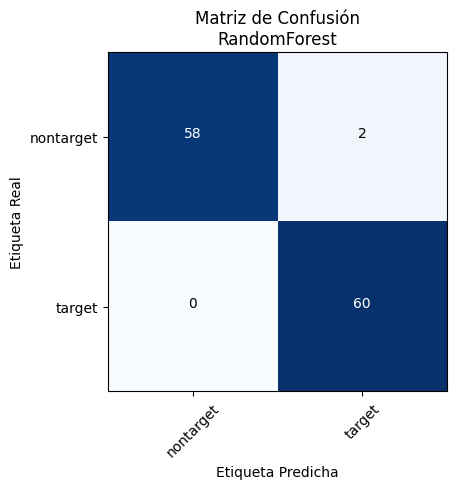


=== Evaluando SVM en P2_high2.mat ===

Métricas para SVM:
F1-score (nontarget): 0.800
F1-score (target): 0.800
Recall (nontarget): 0.800
Recall (target): 0.800
AUC: 0.800


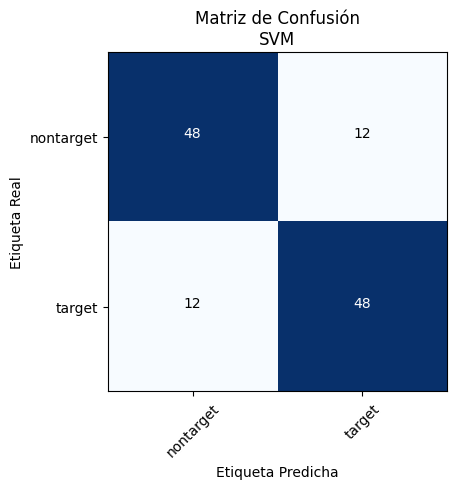


=== Evaluando LogisticRegression en P2_high2.mat ===

Métricas para LogisticRegression:
F1-score (nontarget): 0.877
F1-score (target): 0.889
Recall (nontarget): 0.833
Recall (target): 0.933
AUC: 0.883


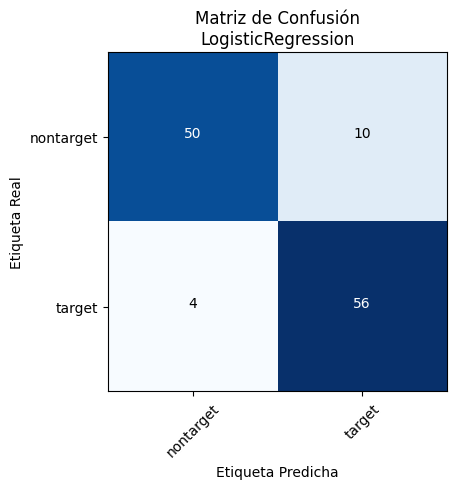


=== Evaluando LDA en P2_high2.mat ===

Métricas para LDA:
F1-score (nontarget): 0.715
F1-score (target): 0.701
Recall (nontarget): 0.733
Recall (target): 0.683
AUC: 0.708


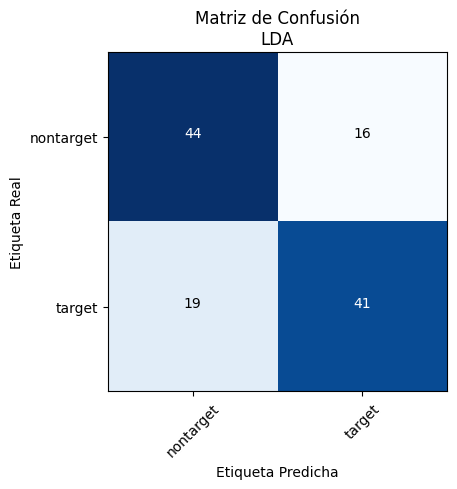

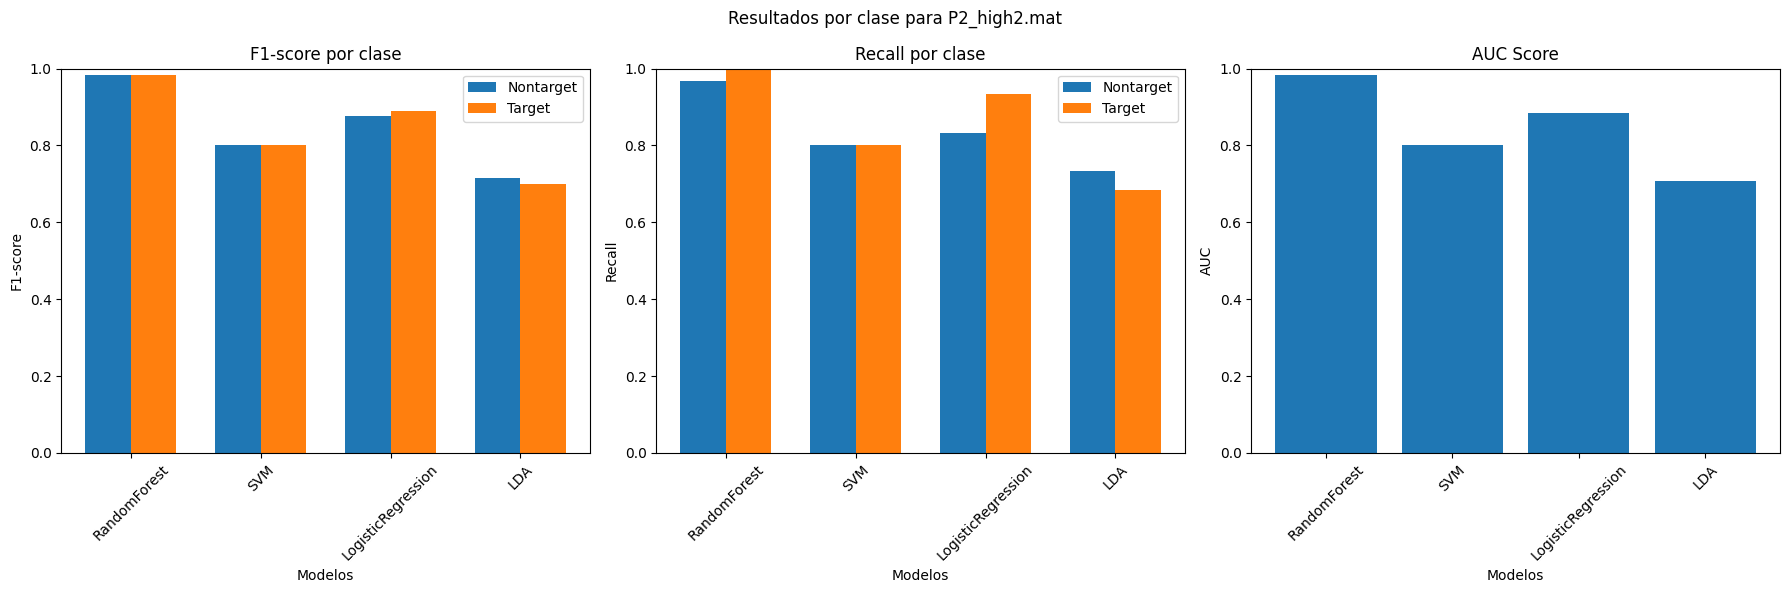


Procesando: P1_low1.mat
Creating RawArray with float64 data, n_channels=8, n_times=39056
    Range : 0 ... 39055 =      0.000 ...   152.559 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=39056
    Range : 0 ... 39055 =      0.000 ...   152.559 secs
Ready.
480 events found on stim channel STI
Event IDs: [1 2 3]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 12 Hz

FIR filter p

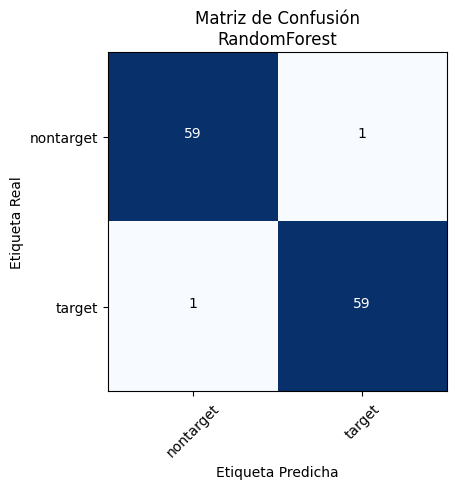


=== Evaluando SVM en P1_low1.mat ===

Métricas para SVM:
F1-score (nontarget): 0.860
F1-score (target): 0.873
Recall (nontarget): 0.817
Recall (target): 0.917
AUC: 0.867


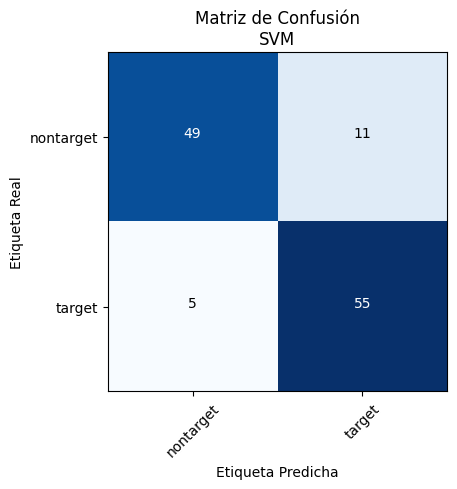


=== Evaluando LogisticRegression en P1_low1.mat ===

Métricas para LogisticRegression:
F1-score (nontarget): 0.915
F1-score (target): 0.918
Recall (nontarget): 0.900
Recall (target): 0.933
AUC: 0.917


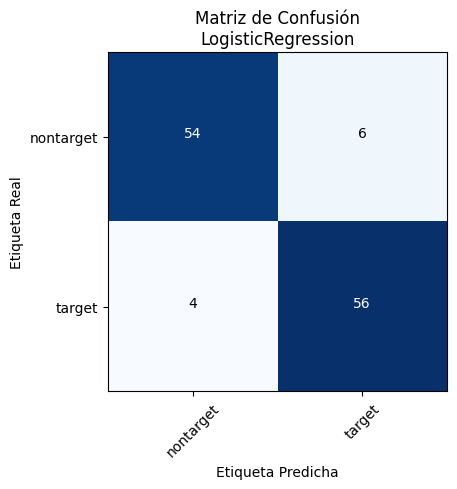


=== Evaluando LDA en P1_low1.mat ===

Métricas para LDA:
F1-score (nontarget): 0.803
F1-score (target): 0.797
Recall (nontarget): 0.817
Recall (target): 0.783
AUC: 0.800


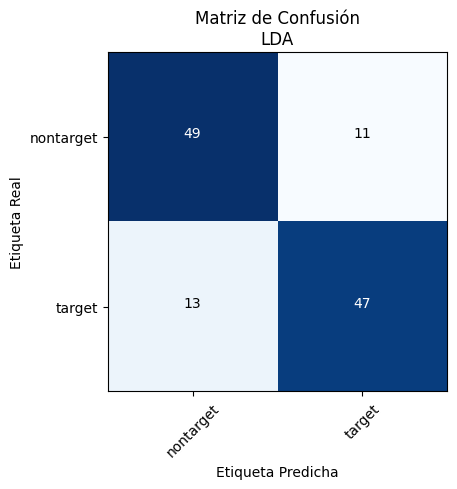

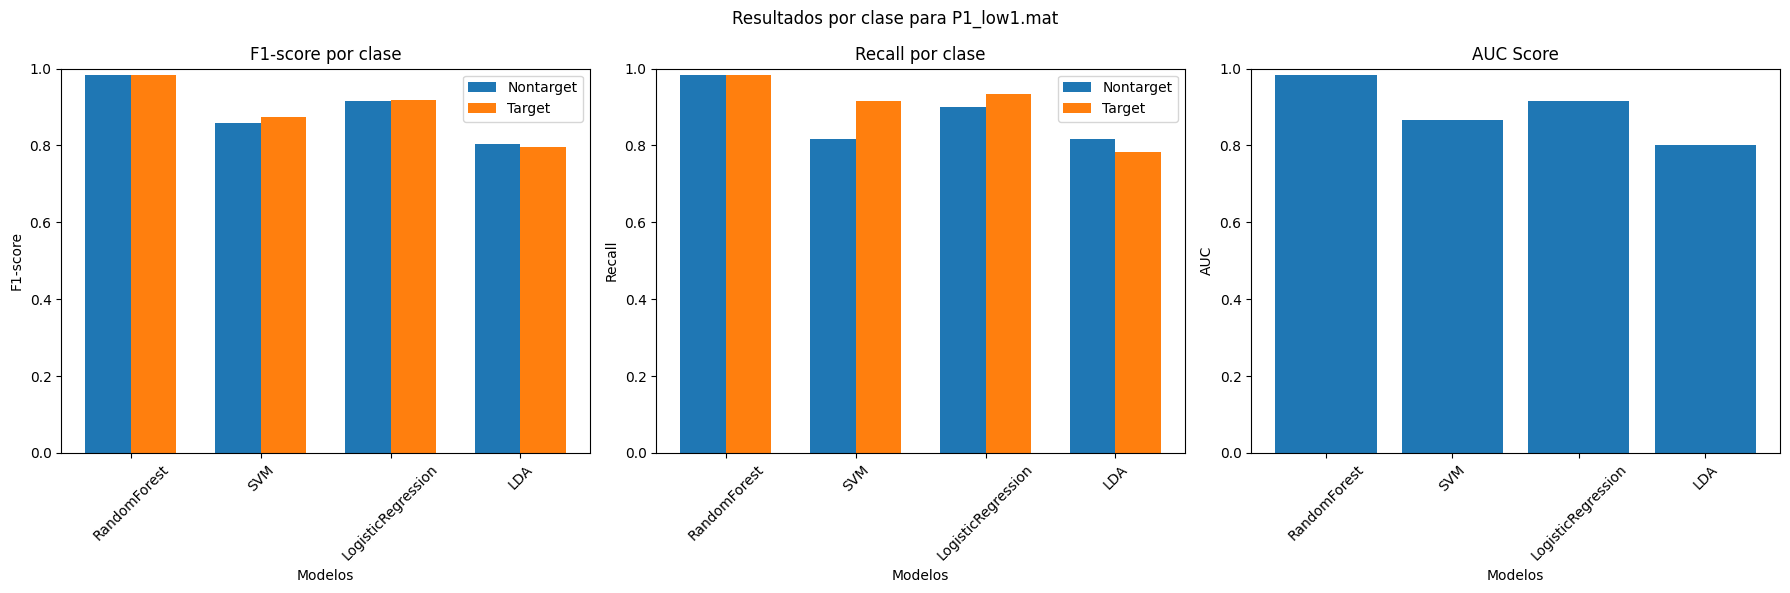


Procesando: P1_low2.mat
Creating RawArray with float64 data, n_channels=8, n_times=39048
    Range : 0 ... 39047 =      0.000 ...   152.527 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=39048
    Range : 0 ... 39047 =      0.000 ...   152.527 secs
Ready.
480 events found on stim channel STI
Event IDs: [1 2 3]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 12 Hz

FIR filter p

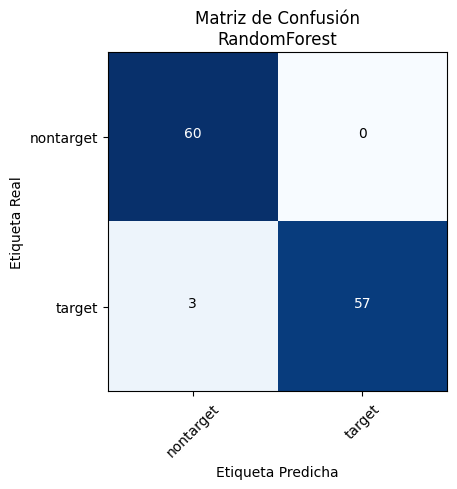


=== Evaluando SVM en P1_low2.mat ===

Métricas para SVM:
F1-score (nontarget): 0.873
F1-score (target): 0.860
Recall (nontarget): 0.917
Recall (target): 0.817
AUC: 0.867


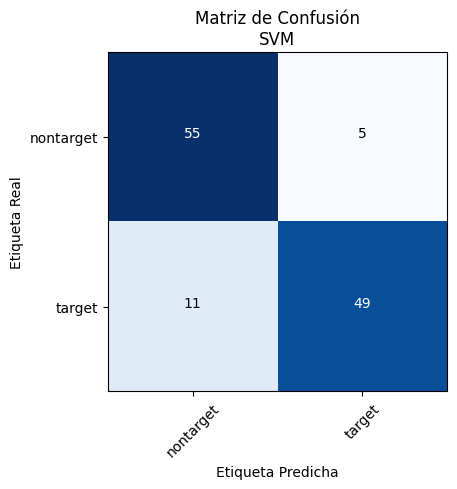


=== Evaluando LogisticRegression en P1_low2.mat ===

Métricas para LogisticRegression:
F1-score (nontarget): 0.874
F1-score (target): 0.876
Recall (nontarget): 0.867
Recall (target): 0.883
AUC: 0.875


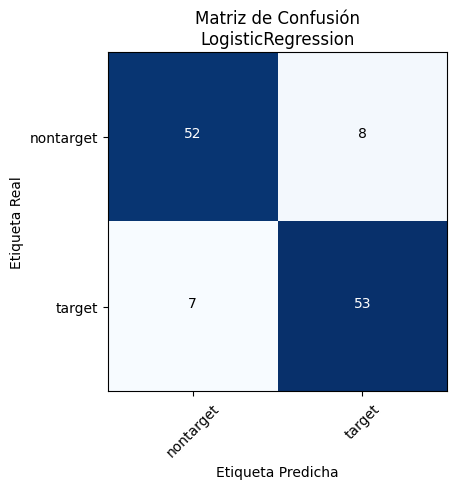


=== Evaluando LDA en P1_low2.mat ===

Métricas para LDA:
F1-score (nontarget): 0.729
F1-score (target): 0.738
Recall (nontarget): 0.717
Recall (target): 0.750
AUC: 0.733


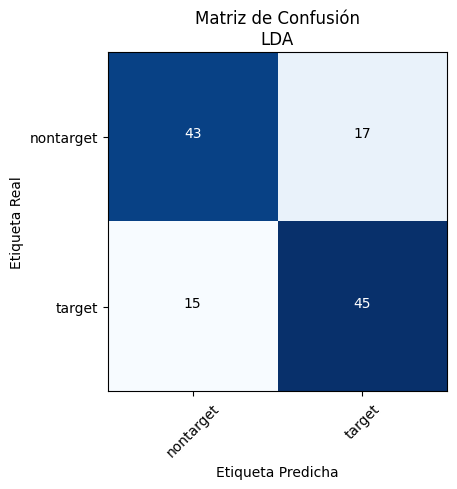

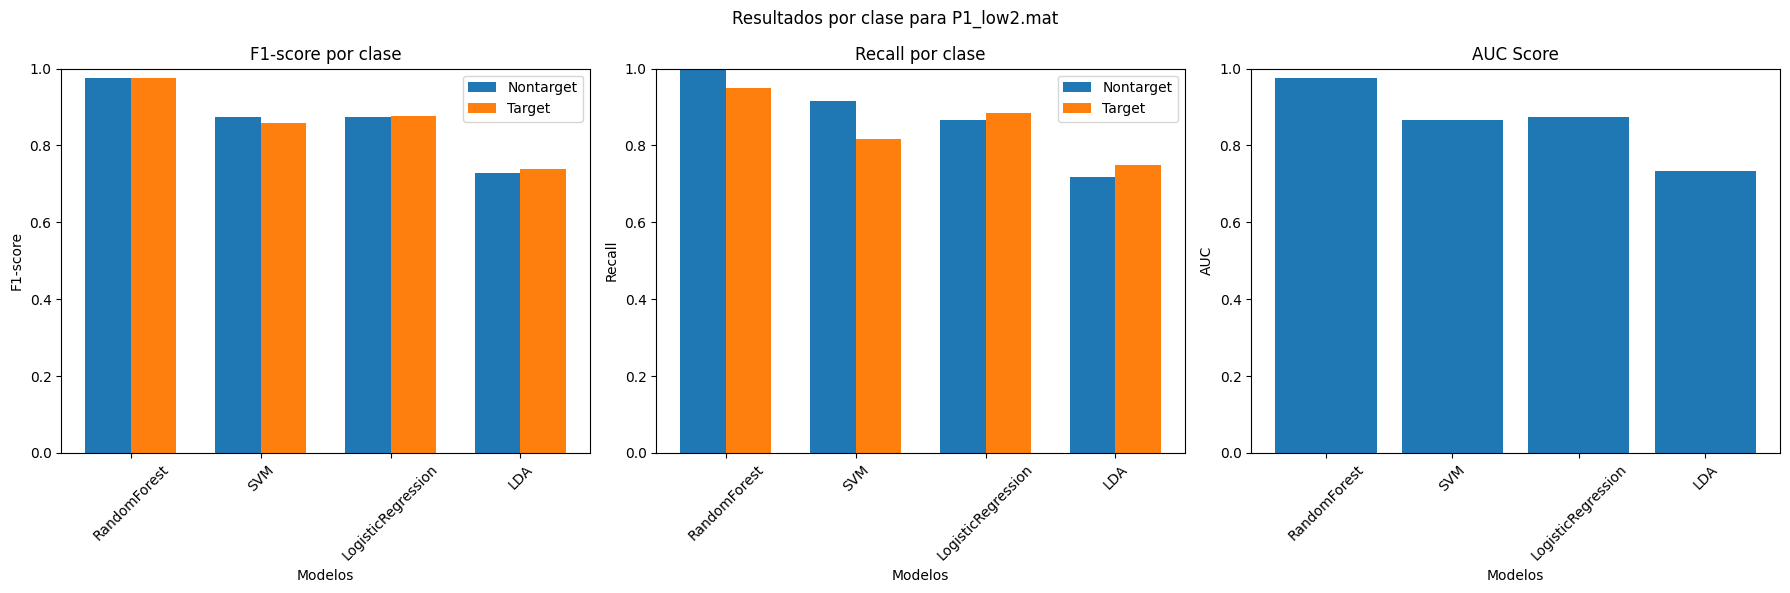


Procesando: P2_low1.mat
Creating RawArray with float64 data, n_channels=8, n_times=39440
    Range : 0 ... 39439 =      0.000 ...   154.059 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=39440
    Range : 0 ... 39439 =      0.000 ...   154.059 secs
Ready.
480 events found on stim channel STI
Event IDs: [1 2 3]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 12 Hz

FIR filter p

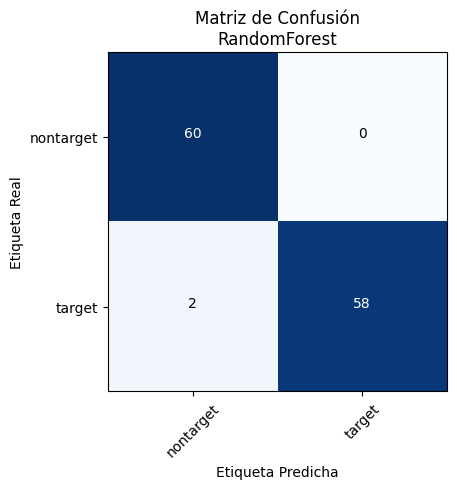


=== Evaluando SVM en P2_low1.mat ===

Métricas para SVM:
F1-score (nontarget): 0.840
F1-score (target): 0.843
Recall (nontarget): 0.833
Recall (target): 0.850
AUC: 0.842


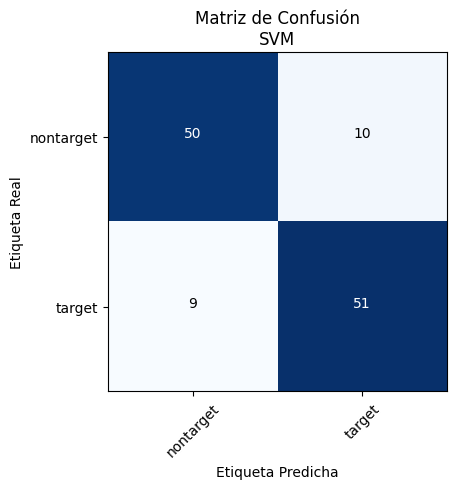


=== Evaluando LogisticRegression en P2_low1.mat ===

Métricas para LogisticRegression:
F1-score (nontarget): 0.878
F1-score (target): 0.872
Recall (nontarget): 0.900
Recall (target): 0.850
AUC: 0.875


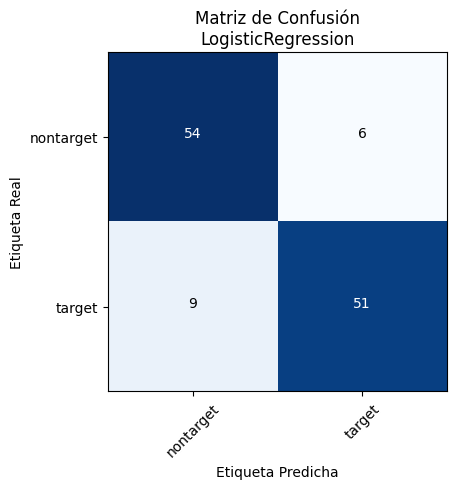


=== Evaluando LDA en P2_low1.mat ===

Métricas para LDA:
F1-score (nontarget): 0.729
F1-score (target): 0.738
Recall (nontarget): 0.717
Recall (target): 0.750
AUC: 0.733


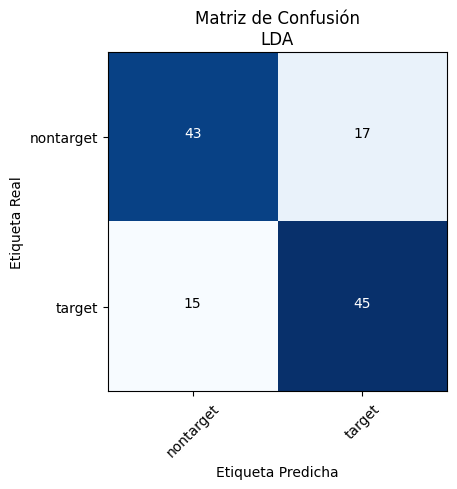

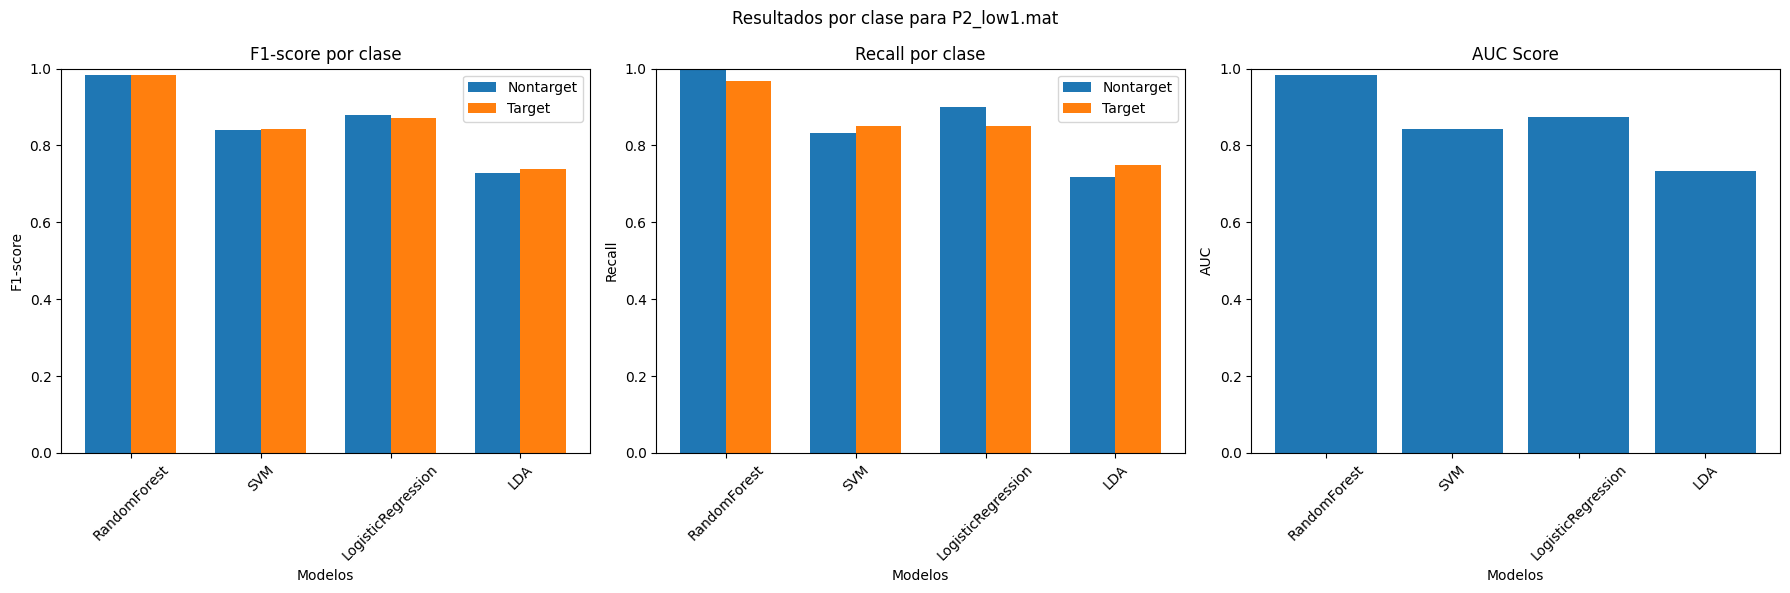


Procesando: P2_low2.mat
Creating RawArray with float64 data, n_channels=8, n_times=39424
    Range : 0 ... 39423 =      0.000 ...   153.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=39424
    Range : 0 ... 39423 =      0.000 ...   153.996 secs
Ready.
480 events found on stim channel STI
Event IDs: [1 2 3]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 12 Hz

FIR filter p

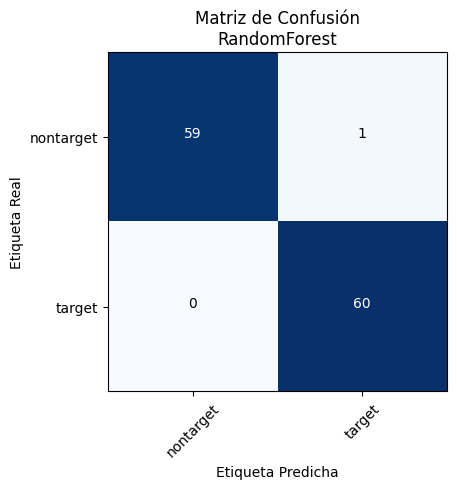


=== Evaluando SVM en P2_low2.mat ===

Métricas para SVM:
F1-score (nontarget): 0.793
F1-score (target): 0.822
Recall (nontarget): 0.733
Recall (target): 0.883
AUC: 0.808


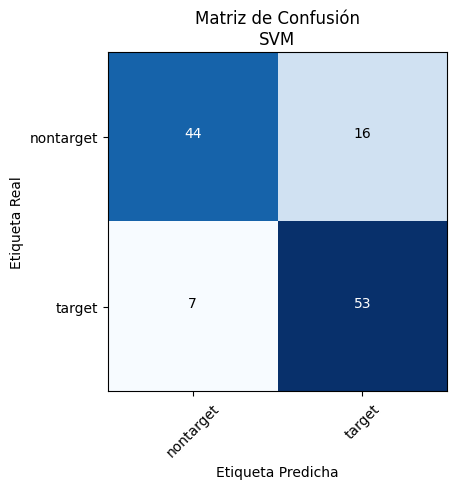


=== Evaluando LogisticRegression en P2_low2.mat ===

Métricas para LogisticRegression:
F1-score (nontarget): 0.900
F1-score (target): 0.900
Recall (nontarget): 0.900
Recall (target): 0.900
AUC: 0.900


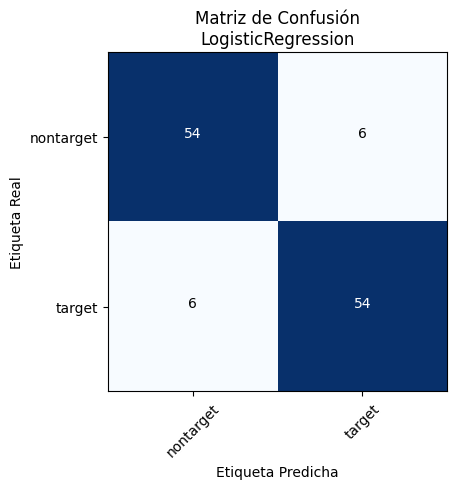


=== Evaluando LDA en P2_low2.mat ===

Métricas para LDA:
F1-score (nontarget): 0.793
F1-score (target): 0.790
Recall (nontarget): 0.800
Recall (target): 0.783
AUC: 0.792


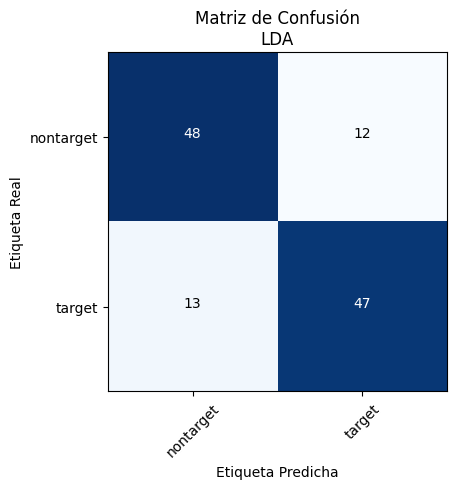

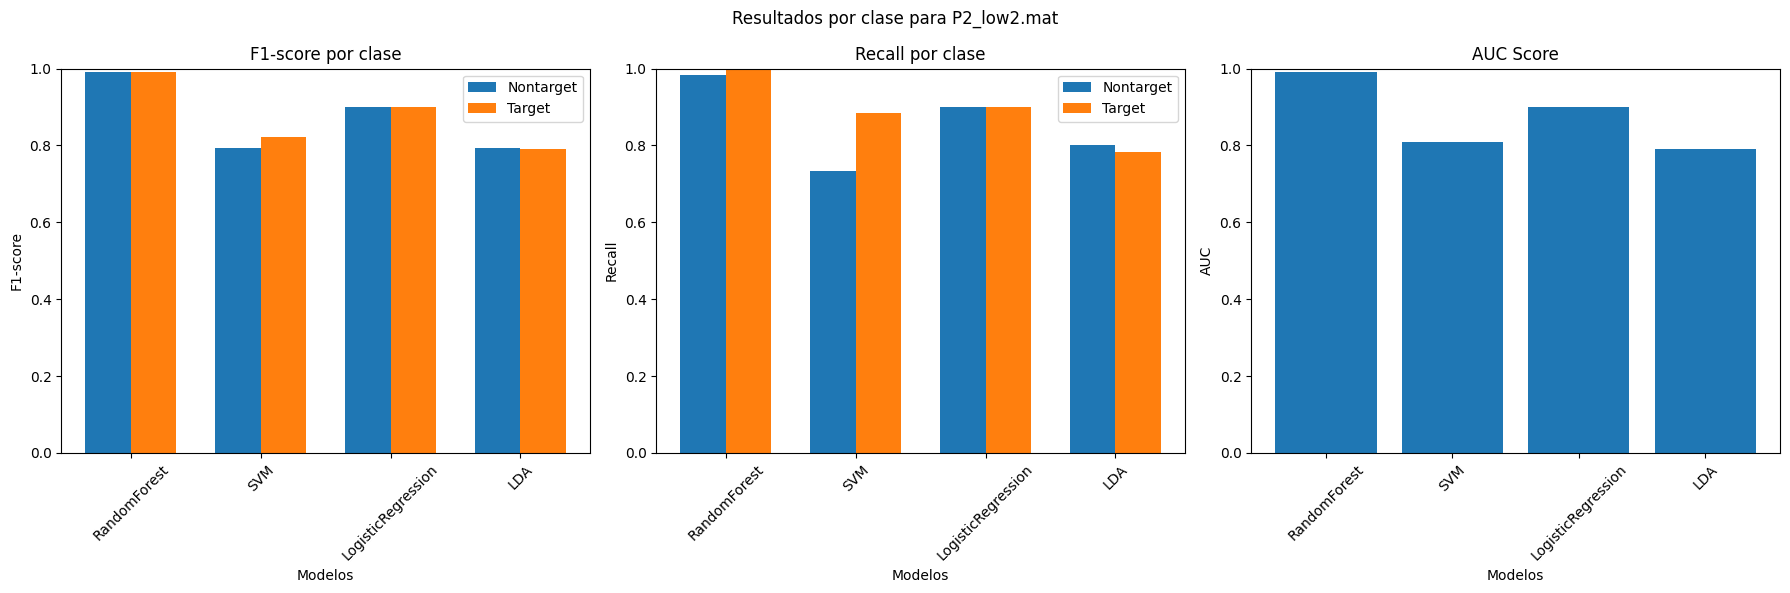



REPORTE FINAL COMPARATIVO

F1_NONTARGET:
P1_high1.mat    - RandomForest: 1.000, SVM: 0.842, LogisticRegression: 0.885, LDA: 0.754
P1_high2.mat    - RandomForest: 0.975, SVM: 0.789, LogisticRegression: 0.957, LDA: 0.814
P2_high1.mat    - RandomForest: 0.983, SVM: 0.758, LogisticRegression: 0.700, LDA: 0.730
P2_high2.mat    - RandomForest: 0.983, SVM: 0.800, LogisticRegression: 0.877, LDA: 0.715
P1_low1.mat     - RandomForest: 0.983, SVM: 0.860, LogisticRegression: 0.915, LDA: 0.803
P1_low2.mat     - RandomForest: 0.976, SVM: 0.873, LogisticRegression: 0.874, LDA: 0.729
P2_low1.mat     - RandomForest: 0.984, SVM: 0.840, LogisticRegression: 0.878, LDA: 0.729
P2_low2.mat     - RandomForest: 0.992, SVM: 0.793, LogisticRegression: 0.900, LDA: 0.793

F1_TARGET:
P1_high1.mat    - RandomForest: 1.000, SVM: 0.857, LogisticRegression: 0.881, LDA: 0.778
P1_high2.mat    - RandomForest: 0.975, SVM: 0.824, LogisticRegression: 0.959, LDA: 0.835
P2_high1.mat    - RandomForest: 0.983, SVM: 0.741, Logi

In [ ]:
# 6. Procesamiento de múltiples datasets
if __name__ == "__main__":
    datasets = ['P1_high1.mat', 'P1_high2.mat', 'P2_high1.mat', 'P2_high2.mat', 'P1_low1.mat', 'P1_low2.mat', 'P2_low1.mat', 'P2_low2.mat']
    starting_dir = "/content/drive/MyDrive/Hackathon/"

    all_results = {}
    for dataset in datasets:
        all_results[dataset] = process_dataset(dataset, starting_dir)

    # Reporte final comparativo
    print("\n\nREPORTE FINAL COMPARATIVO")
    metrics = ['f1_nontarget', 'f1_target', 'recall_nontarget', 'recall_target', 'auc']

    for metric in metrics:
        print(f"\n{metric.upper()}:")
        for dataset in all_results:
            if all_results[dataset] is None:
                continue

            values = []
            for model in all_results[dataset]:
                if isinstance(all_results[dataset][model], dict):
                    val = all_results[dataset][model].get(metric, 0)
                    values.append(f"{model}: {val:.3f}")
            print(f"{dataset:15} - {', '.join(values)}")